In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

In [4]:
# clean speech
cl, fs = wavread("sound/speech/sp02.wav")
σ² = 0.0001
# white noise
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn
wavwrite(ns, "sound/mixed/white_speech.wav")

In [5]:
# dividing into 10ms frames with 2.5ms overlap
start = 1
l = Int(round(0.01*fs))
overlap = Int(round(0.0025*fs))
totseg = Int(ceil(length(ns)/(l-overlap)))
segment = zeros(totseg, l)
zseg = zeros(totseg, l)
for i in 1:totseg - 1
    global start
    segment[i,1:l]=ns[start:start+l-1]
    zseg[i, 1:l] = cl[start:start+l-1]
    start = (l-overlap)*i+1
end
segment[totseg, 1:length(ns)-start+1] = ns[start:length(ns)]
zseg[totseg, 1:length(cl)-start+1] = cl[start:length(cl)];

In [6]:
function ar_ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ar_ssm (generic function with 1 method)

In [7]:
@model function lar_model(n, order, artype, c)

    x = randomvar(n)
    y = datavar(Float64, n)

    γ ~ GammaShapeRate(0.00001, 1.0) where {q=MeanField()}
    θ ~ MvNormalMeanPrecision(randn(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}
    x0 ~ MvNormalMeanPrecision(100.0 * ones(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}
    τ ~ GammaShapeRate(1.0, 1.0) where {q=MeanField()}

    x_prev = x0

    ct  = constvar(c)

    ar_nodes = Vector{FactorNode}(undef, n)

    for i in 1:n
        ar_nodes[i], x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order, ARsafe()) }

        y[i] ~ NormalMeanPrecision(dot(ct, x[i]), τ) where {q=MeanField()}

        x_prev = x[i]
    end

    return x, y, θ, γ, τ, ar_nodes
end

lar_model (generic function with 1 method)

In [8]:
function inference_lar(data, order, niter)
    n = length(data)
    artype = Multivariate
    c = zeros(order); c[1] = 1.0
    model, (x, y, θ, γ, τ, ar_nodes) = lar_model(n, order, artype, c)

    γ_buffer = nothing
    τ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    τsub = subscribe!(getmarginal(τ), (mτ) -> τ_buffer = mτ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(τ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)))

    for i in 1:n
        setmarginal!(ar_nodes[i], :y_x, MvNormalMeanPrecision(100.0 * ones(2*order), Matrix{Float64}(I, 2*order, 2*order)))
    end

    for i in 1:niter
        update!(y, data)
    end

    unsubscribe!(γsub)
    unsubscribe!(τsub)
    unsubscribe!(θsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)

    return γ_buffer, τ_buffer, θ_buffer, x_buffer, fe
end

inference_lar (generic function with 1 method)

In [9]:
@model function gaussian_model(n)

    y = datavar(Float64, n)

    γ ~ GammaShapeRate(1.0, 1.0) where {q=MeanField()}
    x_0 ~ NormalMeanPrecision(0.0, 1.0) where {q=MeanField()}
    x ~ NormalMeanPrecision(x_0, γ) where {q=MeanField()}

    for i in 1:n
        y[i] ~ NormalMeanPrecision(x, 1e4) where {q=MeanField()}
    end

    return y, x, γ
end

gaussian_model (generic function with 1 method)

In [10]:
function inference_gaussian(outputs, niter)
    n = length(outputs)
    model, (y, x, γ) = gaussian_model(n, options = (limit_stack_depth = 500, ))
    γ_buffer = nothing
    x_buffer = nothing
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (my) -> γ_buffer = my)
    xsub = subscribe!(getmarginal(x), (mx) -> x_buffer = mx)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(x, NormalMeanPrecision(0.0, 1.0))

    for i in 1:niter
        update!(y, outputs)
    end

    unsubscribe!(γsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)

    return x_buffer, γ_buffer, fe
end

inference_gaussian (generic function with 1 method)

In [11]:
ar_order = 5
vmp_iter = 50
fe_ar = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);

In [12]:
ProgressMeter.@showprogress for segnum in 1:totseg
    inputs, outputs = ar_ssm(segment[segnum, :], ar_order)
    γ, τ, θ, x, fe = inference_lar(outputs, ar_order, vmp_iter)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_ar[segnum, :] = fe
    
    x, γ, fe = inference_gaussian(outputs, vmp_iter)
    mx, vx = mean(x), cov(x)
    mγ = mean(γ)
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:51


In [13]:
vad = [x[end] < y[end] for (x, y) in zip(eachrow(fe_ar), eachrow(fe_gaussian))]

352-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [14]:
findall(isequal(1), vad)

153-element Vector{Int64}:
  32
  33
  34
  35
  36
  37
  38
  39
  40
  41
  42
  43
  44
   ⋮
 251
 252
 253
 254
 255
 256
 259
 290
 291
 292
 293
 295

In [15]:
fe_gaussian[32, :]

50-element Vector{Float64}:
 298.7457890896569
 298.7381727993475
 298.7380879128901
 298.738087038243
 298.73808702930825
 298.7380870292173
 298.7380870292162
 298.7380870292162
 298.7380870292163
 298.7380870292161
 298.7380870292162
 298.7380870292162
 298.73808702921633
   ⋮
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162
 298.7380870292162

In [16]:
fe_ar[32, :]

50-element Vector{Float64}:
 1469.0787253041153
  281.4168682174409
  279.2638419225784
  277.0278909067422
  274.59523072726483
  271.95372326150505
  269.0627570702356
  265.907348363471
  262.4379978721265
  258.60904071468383
  254.38309196520322
  249.68854577626087
  244.44658933004564
    ⋮
   65.97097396222102
   65.97098999587979
   65.9709679814946
   65.97096923988602
   65.97100355057319
   65.97094137904674
   65.97094580826297
   65.97098093557997
   65.97102851336535
   65.97092616718032
   65.97104398443366
   65.97098832121856

In [17]:
rseg = 200

200

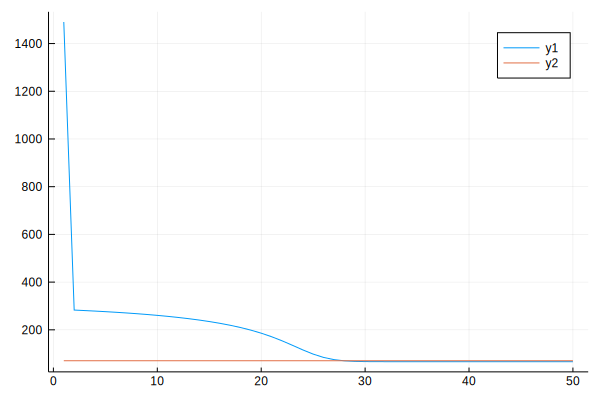

In [18]:
plot(fe_ar[rseg, :])
plot!(fe_gaussian[rseg, :])

In [23]:
println("$(fe_gaussian[rseg, :][end]), $(fe_ar[rseg, :][end])")

70.39462649703847, 66.45549685430046


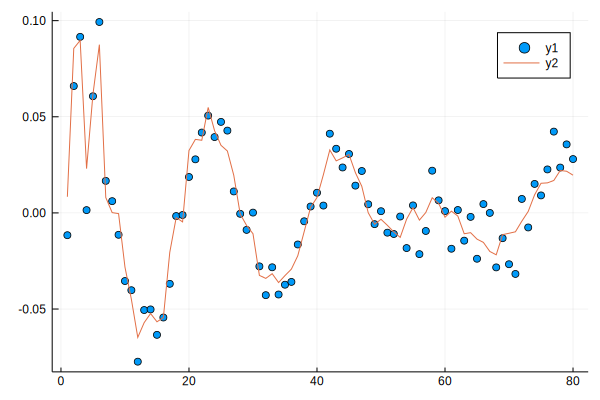

In [19]:
scatter(segment[rseg, :])
plot!(zseg[rseg, :])